In [1]:
# from google.colab import drive
# drive.mount('/content/drive/')

# %cd /content/drive/MyDrive/ChesapeakeBay/ChesapeakeBayChlorophyll/notebooks/models

# Set up

In [14]:
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import os

import logging
from tqdm.notebook import tqdm  # For progress bar
# Configure logging instead of print
logging.basicConfig(filename='tuning.log', level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import ParameterGrid
import json
from concurrent.futures import ThreadPoolExecutor, as_completed

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


In [2]:
# Load tensors
# features_tensor = torch.load('../../data/features_masked_tensor.pt')
# chlorophyll_tensor = torch.load('../../data/chlorophyll_masked_tensor.pt')

features_tensor_dict = {}

for i in range(11):
    # Load tensors using formatted string (f-string)
    features_tensor = torch.load(f'../../data/filesForModel/tensors/features_region{i}_tensor.pt')
    chlorophyll_tensor = torch.load(f'../../data/filesForModel/tensors/chlorophyll_region{i}_tensor.pt')

    # # Attach names to tensor dimensions
    # features_tensor.names = ('time','features','position')
    # chlorophyll_tensor.names = ('time','position')

    # Store the tensors in the dictionary
    features_tensor_dict[f'region_{i}_features'] = features_tensor
    features_tensor_dict[f'region_{i}_chlorophyll'] = chlorophyll_tensor

    print(f"Region {i}: features tensor shape: {features_tensor.shape}, chlorophyll tensor shape: {chlorophyll_tensor.shape}")


Region 0: features tensor shape: torch.Size([2767, 7, 127]), chlorophyll tensor shape: torch.Size([2767, 127])
Region 1: features tensor shape: torch.Size([2767, 7, 236]), chlorophyll tensor shape: torch.Size([2767, 236])
Region 2: features tensor shape: torch.Size([2767, 7, 311]), chlorophyll tensor shape: torch.Size([2767, 311])
Region 3: features tensor shape: torch.Size([2767, 7, 769]), chlorophyll tensor shape: torch.Size([2767, 769])
Region 4: features tensor shape: torch.Size([2767, 7, 1234]), chlorophyll tensor shape: torch.Size([2767, 1234])
Region 5: features tensor shape: torch.Size([2767, 7, 602]), chlorophyll tensor shape: torch.Size([2767, 602])
Region 6: features tensor shape: torch.Size([2767, 7, 1251]), chlorophyll tensor shape: torch.Size([2767, 1251])
Region 7: features tensor shape: torch.Size([2767, 7, 335]), chlorophyll tensor shape: torch.Size([2767, 335])
Region 8: features tensor shape: torch.Size([2767, 7, 195]), chlorophyll tensor shape: torch.Size([2767, 195

# Model

We will create create a data stream for each of the 11 regions. Within each of these regions, we use a long short-term memory model (LSTM) to predict the chlorophyll values at each point.

Since the regions are highly irregular in shape, the position grid (latitude and longitude) contains a lot of points outside of the region. These positions have NaN for every variable, so we need to mask them in our model.

## Defining the classes

In [3]:
import torch
import torch.nn as nn

class RegionalLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size,h0=None, c0=None):
        super(RegionalLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)


        # Store hidden states if needed
        self.h0 = h0
        self.c0 = c0
    def forward(self, x, h0=None, c0=None, time_batch_size= 100):
        # x shape: (batch_size, time_steps, variables, position)
        batch_size, time_steps, variables, positions = x.size()
        x = x.to(device)
        # Reshape to (batch_size * position, time_steps, variables) to treat each position separately
        x = x.permute(0, 3, 1, 2).reshape(batch_size * positions, time_steps, variables)

        # If no hidden state provided, initialize hidden states
        if h0 is None or c0 is None:
            h0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to(x.device)
            c0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to(x.device)


        # Adjust mini-batching to handle cases where time_steps < time_batch_size
        outputs = []
        for start in range(0, time_steps, time_batch_size):
            end = min(start + time_batch_size, time_steps)
            x_time_batch = x[:, start:end, :]  # Mini-batch along time
            
            # Forward pass through the LSTM with hidden state carryover
            lstm_out, (h0, c0) = self.lstm(x_time_batch, (h0, c0))  # Keep hidden state across time mini-batches
            
            outputs.append(lstm_out)
        
        # Concatenate the outputs for all time mini-batches
        lstm_out = torch.cat(outputs, dim=1)  # Concatenate along the time dimension
        
        # Apply the fully connected layer at every time step for each position
        out = self.fc(lstm_out)  # Shape: (batch_size * positions, time_steps, output_size)
        
        # Reshape back to (batch_size, time_steps, positions)
        out = out.view(batch_size, positions, time_steps).permute(0, 2, 1)

        
        return out, (h0,c0)


Since the relationship between regions comes from a map, we will hard code the data. Simply using a 1 if the regions border each other and 0 if they do not.

In [4]:
# Neighbor mask matrix (as described earlier)
neighbor_mask = torch.tensor([
    [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],  # Region 0, CB1TF
    [1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],  # Region 1, CB2OH
    [0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0],  # Region 2, CB3MH
    [0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0],  # Region 3, CB4MH
    [0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1],  # Region 4, CB5MH
    [0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0],  # Region 5, CB6PH
    [0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1],  # Region 6, CB7PH
    [0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0],  # Region 7, CB8PH
    [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],  # Region 8, EASMH
    [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],  # Region 9, MOBPH
    [0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0]   # Region 110, TANMH
], dtype=torch.float32)

# All regions?

In [5]:
train_features_dict = {}
val_features_dict = {}
test_features_dict = {}
train_targets_dict = {}
val_targets_dict = {}
test_targets_dict = {}

# feature shape (time, variables, position)
# chlorophyll shape (time, position)
for region_id in range(11):
    # Access the features and chlorophyll tensors from the dictionary
    features_tensor = features_tensor_dict[f'region_{region_id}_features']
    chlorophyll_tensor = features_tensor_dict[f'region_{region_id}_chlorophyll']

    # reshape to (batch, time, variables, position)
    features_tensor = features_tensor.unsqueeze(0)
    chlorophyll_tensor = chlorophyll_tensor.unsqueeze(0)
    
    # Split data into 70% training, 15% validation, 15% test
    train_size = int(0.7 * features_tensor.shape[1])  # 70% of the time steps
    val_size = int(0.15 * features_tensor.shape[1])   # 15% for validation
    test_size = features_tensor.shape[1] - train_size - val_size  # Remaining for test set

    # Split features into train, validation, and test sets
    train_features = features_tensor[:, :train_size, :, :]  # First 70% for training
    val_features = features_tensor[:, train_size:train_size+val_size, :, :]  # Next 15% for validation
    test_features = features_tensor[:, train_size+val_size:, :, :]  # Remaining for test
    
    # Split chlorophyll targets (same logic)
    train_targets = chlorophyll_tensor[:, :train_size, :]  # First 70% for training
    val_targets = chlorophyll_tensor[:, train_size:train_size+val_size, :]  # Next 15% for validation
    test_targets = chlorophyll_tensor[:, train_size+val_size:, :]  # Remaining for test

    # Store the splits in dictionaries
    # Also correct the indexing
    train_features_dict[f'region_{region_id}'] = train_features
    val_features_dict[f'region_{region_id}'] = val_features
    test_features_dict[f'region_{region_id}'] = test_features
    
    train_targets_dict[f'region_{region_id}'] = train_targets
    val_targets_dict[f'region_{region_id}'] = val_targets
    test_targets_dict[f'region_{region_id}'] = test_targets

    # Print shapes for verification
    print(f"Region {region_id}: Train features {train_features.shape}, Validation features {val_features.shape}, Test features {test_features.shape}")
    print(f"Region {region_id}: Train targets {train_targets.shape}, Validation targets {val_targets.shape}, Test targets {test_targets.shape}")


Region 0: Train features torch.Size([1, 1936, 7, 127]), Validation features torch.Size([1, 415, 7, 127]), Test features torch.Size([1, 416, 7, 127])
Region 0: Train targets torch.Size([1, 1936, 127]), Validation targets torch.Size([1, 415, 127]), Test targets torch.Size([1, 416, 127])
Region 1: Train features torch.Size([1, 1936, 7, 236]), Validation features torch.Size([1, 415, 7, 236]), Test features torch.Size([1, 416, 7, 236])
Region 1: Train targets torch.Size([1, 1936, 236]), Validation targets torch.Size([1, 415, 236]), Test targets torch.Size([1, 416, 236])
Region 2: Train features torch.Size([1, 1936, 7, 311]), Validation features torch.Size([1, 415, 7, 311]), Test features torch.Size([1, 416, 7, 311])
Region 2: Train targets torch.Size([1, 1936, 311]), Validation targets torch.Size([1, 415, 311]), Test targets torch.Size([1, 416, 311])
Region 3: Train features torch.Size([1, 1936, 7, 769]), Validation features torch.Size([1, 415, 7, 769]), Test features torch.Size([1, 416, 7,

# Try sharing

In [61]:
import torch.nn.functional as F

class MultiRegionModel(nn.Module):
    def __init__(self, neighbor_mask, input_size, hidden_size, num_layers, output_size):
        super(MultiRegionModel, self).__init__()
        self.neighbor_mask = neighbor_mask
        self.regions = nn.ModuleList([
            RegionalLSTM(input_size, hidden_size, num_layers, output_size) 
            for _ in range(neighbor_mask.shape[0])
        ])


    def forward(self, region_inputs):
        # region_inputs should be a dictionary where keys are region IDs and values are feature tensors
        region_outputs = {}  # Initialize a dictionary to store outputs for each region

        for region_id, region_data in region_inputs.items():
            # Assuming region_id can be converted to an index
            region_index = int(region_id[-1])
            # Initialize combined_h0 for the first pass
            position_size = region_data.shape[-1]
            current_h0 = torch.zeros((batch_size, position_size, self.regions[region_index].lstm.hidden_size)).to(device)  # Replace with appropriate shape

            # Find neighbors
            neighbors = [i for i in range(1, self.neighbor_mask.shape[0] ) if self.neighbor_mask[region_index, i] == 1]

            neighbor_hidden_states = []
            for neighbor_index in neighbors:
                _, (neighbor_h0, neighbor_c0) = self.regions[neighbor_index](region_data)  # Use region_data for the neighbor

                neighbor_hidden_states.append(neighbor_h0)
                # Assuming neighbor_hidden_states is a list of (batch_size * positions, time_steps, hidden_size) tensors
            if neighbor_hidden_states:
                aggregated_neighbors_h0 = torch.mean(torch.stack(neighbor_hidden_states), dim=0).to(device)  # Mean across neighbors

            # Combine current hidden state with aggregated neighbor hidden states
            combined_h0 = current_h0 + F.interpolate(aggregated_neighbors_h0, size=current_h0.shape[-1], mode='linear', align_corners=False).to(device)
            # Adjust this operation as needed

            # Call the RegionalLSTM with the current input and updated hidden states
            output, (current_h0, current_c0) = self.regions[region_index](region_data, combined_h0, neighbor_c0)

            # Store the output for the current region
            region_outputs[region_id] = output.to(device)# Store the output for the current region
        return region_outputs  # Return the dictionary of outputs for each region


## Hypertuning

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import ParameterGrid
import json
import os


def train_and_evaluate_model(model, train_features_dict, train_targets_dict, val_features_dict, val_targets_dict, learning_rate,num_epochs):

    # Define loss function and optimizer
    criterion = nn.MSELoss()  # Mean Squared Error for regression
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Move model to GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    last_outputs_dict = {region_id: [] for region_id in train_features_dict.keys()}
    validation_losses = {region_id: [] for region_id in val_features_dict.keys()}
    region_models ={}

    total_iterations = num_epochs * len(train_features_dict)

    with tqdm(total=total_iterations, desc="Processing Model", leave=True) as pbar:
        for epoch in range(num_epochs):
          for region_id, features in train_features_dict.items():

                targets = train_targets_dict[region_id]

                features = features.to(device)
                targets = targets.to(device)
                
                model.train() # Ensure the model is in training mode before each training step

                # Forward pass: get the outputs for all regions
                region_outputs = model({region_id: features})
                
                region_models[region_id]=model
                # Retrieve output for the specific region
                output = region_outputs[region_id]
                
                # Store for SHAP 
                last_outputs_dict[region_id].append(output.detach().cpu().numpy())  # Detach and move to CPU if necessary

                # Compute loss
                loss = criterion(output, targets)

                # Backpropagation and optimization steps
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                # Validation step 
                model.eval()  # Set model to evaluation mode
                val_features = val_features_dict[region_id].to(device)
                val_targets = val_targets_dict[region_id].to(device)

                with torch.no_grad():  # Disable gradient calculation for validation
                    val_region_outputs = model({region_id:val_features})
                    val_output = val_region_outputs[region_id]
                    val_loss = criterion(val_output, val_targets)
                    validation_losses[region_id].append(val_loss.item())  # Store the loss in the dictionary

                del val_features, val_targets, val_region_outputs  # Clear these variables
                pbar.update(1)  # Increment the outer progress bar by 1

    return validation_losses  # Return losses for each region separately



First, we will plot the validation loss for various learning rates to determine a range for hypertuning.

Processing Model: 100%|██████████| 110/110 [09:31<00:00,  5.19s/it]


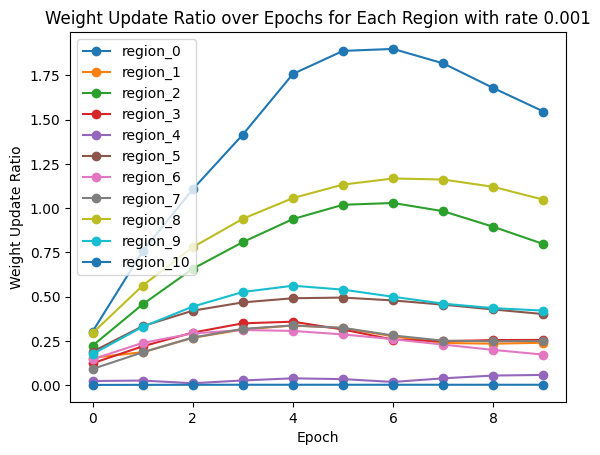

Processing Model: 100%|██████████| 110/110 [09:09<00:00,  4.99s/it]


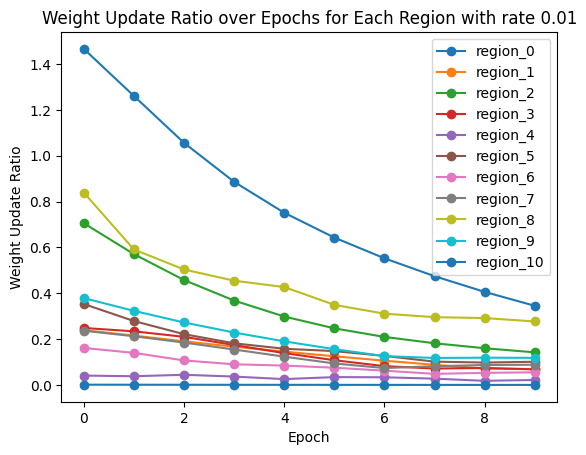

Processing Model: 100%|██████████| 110/110 [07:55<00:00,  4.32s/it]


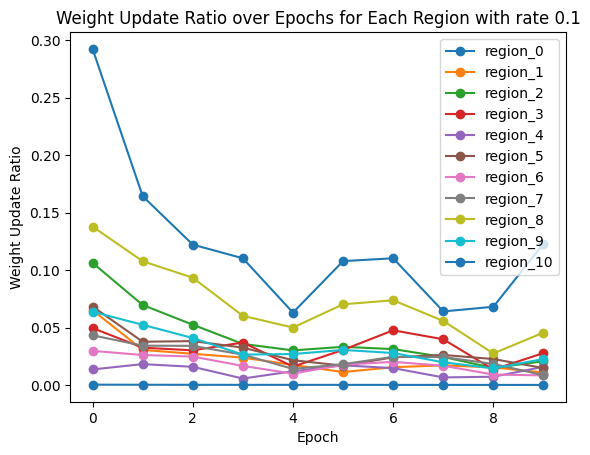

In [29]:
# Example values
learning_rates = [0.001, 0.01, 0.1]
num_epochs = 10
batch_size = 1 

model = MultiRegionModel(neighbor_mask, input_size=7,
                        hidden_size=8, num_layers=2, 
                        output_size=1)  # output_size is fixed

for lr in learning_rates:
    
    # Define loss function and optimizer
    criterion = nn.MSELoss()  # Mean Squared Error for regression
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Move model to GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    total_iterations = num_epochs * len(train_features_dict)
    weight_update_ratios= {region_id: [] for region_id in train_features_dict.keys()}

    with tqdm(total=total_iterations, desc="Processing Model", leave=True) as pbar:
        for epoch in range(num_epochs):
          for region_id, features in train_features_dict.items():
                formatted_region_id = region_id.replace("region_", "regions.")

                targets = train_targets_dict[region_id]

                features = features.to(device)
                targets = targets.to(device)
                
                # Forward pass: get the outputs for all regions
                region_outputs = model({region_id: features})
                # Retrieve output for the specific region
                output = region_outputs[region_id]

                # Compute the loss for the specific region
                loss = criterion(output, targets)

                # Backward pass: compute gradients
                loss.backward()

                # Compute weight update ratio for the specific region
                total_weight_norm = 0.0
                total_update_norm = 0.0

                # Iterate over model parameters associated with the current region
                for name, param in model.named_parameters():
                    # print(name)
                    if param.grad is not None and formatted_region_id in name:
                        weight_norm = torch.norm(param.data).item()
                        update_norm = torch.norm(param.grad.data).item()
                        total_weight_norm += weight_norm
                        total_update_norm += update_norm

                # Avoid division by zero
                if total_weight_norm != 0:
                    weight_update_ratio = total_update_norm / total_weight_norm
                else:
                    weight_update_ratio = 0

                # Store the weight update ratio for the current region
                weight_update_ratios[region_id].append(weight_update_ratio)

                # Update the model parameters
                optimizer.step()

                pbar.update(1)
    # Plot the weight update ratios for each region
    for region_id, ratios in weight_update_ratios.items():
        plt.plot(ratios, marker='o', label=region_id)

    # Add labels and title
    plt.xlabel('Epoch')
    plt.ylabel('Weight Update Ratio')
    plt.title(f'Weight Update Ratio over Epochs for Each Region with rate {lr}')
    plt.legend()
    plt.show()


Processing Model with 1 Layers:   0%|          | 0/110 [00:00<?, ?it/s]

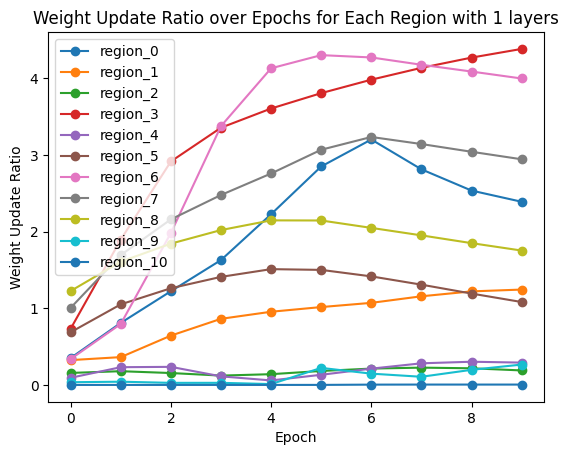

Processing Model with 2 Layers:   0%|          | 0/110 [00:00<?, ?it/s]

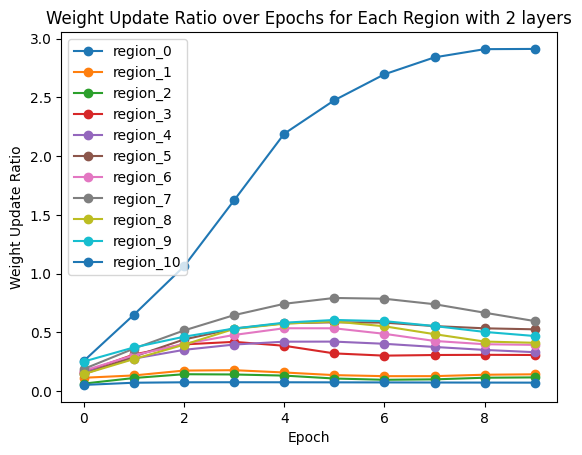

Processing Model with 3 Layers:   0%|          | 0/110 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [62]:

# Define parameters here
lr = 0.001
num_epochs = 10
num_layers_options = [1, 2, 3, 4, 5]  # Example layer configurations


for layers in num_layers_options:
    model = MultiRegionModel(neighbor_mask, input_size=7, hidden_size=8, num_layers=layers, output_size=1)

    criterion = nn.MSELoss()  # Mean Squared Error for regression
    optimizer = optim.Adam(model.parameters(), lr=lr)

    device = torch.device("cpu")  # Use CPU
    model.to(device)

    total_iterations = num_epochs * len(train_features_dict)
    weight_update_ratios = {region_id: [] for region_id in train_features_dict.keys()}

    with tqdm(total=total_iterations, desc=f"Processing Model with {layers} Layers", leave=True) as pbar:
        for epoch in range(num_epochs):
            for region_id, features in train_features_dict.items():
                formatted_region_id = region_id.replace("region_", "regions.")

                targets = train_targets_dict[region_id]

                features = features.to(device)
                targets = targets.to(device)
                
                # Forward pass: get the outputs for all regions
                region_outputs = model({region_id: features})
                # Retrieve output for the specific region
                output = region_outputs[region_id]

                # Compute the loss for the specific region
                loss = criterion(output, targets)

                # Backward pass: compute gradients
                loss.backward()

                # Compute weight update ratio for the specific region
                total_weight_norm = 0.0
                total_update_norm = 0.0

                # Iterate over model parameters associated with the current region
                for name, param in model.named_parameters():
                    # print(name)
                    if param.grad is not None and formatted_region_id in name:
                        weight_norm = torch.norm(param.data).item()
                        update_norm = torch.norm(param.grad.data).item()
                        total_weight_norm += weight_norm
                        total_update_norm += update_norm

                # Avoid division by zero
                if total_weight_norm != 0:
                    weight_update_ratio = total_update_norm / total_weight_norm
                else:
                    weight_update_ratio = 0

                # Store the weight update ratio for the current region
                weight_update_ratios[region_id].append(weight_update_ratio)

                # Update the model parameters
                optimizer.step()

                pbar.update(1)
                # Store results for this model configuration

    # Plot the weight update ratios for each region
    for region_id, ratios in weight_update_ratios.items():
        plt.plot(ratios, marker='o', label=region_id)

    # Add labels and title
    plt.xlabel('Epoch')
    plt.ylabel('Weight Update Ratio')
    plt.title(f'Weight Update Ratio over Epochs for Each Region with {layers} layers')
    plt.legend()
    plt.show()


In [ ]:
def hyperparameter_tuning(params,train_features_dict, train_targets_dict, val_features_dict, val_targets_dict, neighbor_mask):
    checked_params_file = 'checkpoints/checked_params.json'  # Define the path for the checked parameters file
    checkpoint_path = 'checkpoints/model_checkpoint.pt'  # Define the path for the model checkpoint

    if os.path.exists(checked_params_file):
        with open(checked_params_file, 'r') as f:
            checked_params = json.load(f)  # Load as a dictionary
    else:
        checked_params = {}  # Initialize an empty dictionary if no file exists

    if os.path.exists(checkpoint_path):
      checkpoint = torch.load(checkpoint_path)
      
      best_model = checkpoint['model']  # Load the best model
      best_params = checkpoint['params']  # Load the best parameters
      best_ind_validation_loss = checkpoint['indv_validation_loss']  # Load the best individual validation losses
      best_avg_validation_loss = checkpoint['avg_validation_loss']  # Load the best validation loss


    best_model = None
    best_params = None
    best_avg_validation_loss = float('inf')

     # Iterate through each combination of hyperparameters
    for params in ParameterGrid(params):
        print(f"Training with parameters: {params}")
        params_key = json.dumps(params, sort_keys=True)  # Convert the parameters to a JSON string

        if params_key in checked_params:
            continue  # Skip this combination if it has been checked

        model = MultiRegionModel(neighbor_mask, input_size=input_size,
                        hidden_size=params['hidden_size'], num_layers=params['num_layers'], 
                        output_size=1)  # output_size is fixed

        # Initialize the model with the current parameters
        validation_losses = train_and_evaluate_model(
        model.to(device),
        train_features_dict, 
        train_targets_dict, 
        val_features_dict, 
        val_targets_dict, 
        params['learning_rate'],
        params['num_epochs']
    )
        checked_params[params_key] = validation_losses  # Store the validation loss for this combination

        # Save the updated checked parameters dictionary to the file
        with open(checked_params_file, 'w') as f:
            json.dump(checked_params, f)

        # Finds the validation loss for these parameters
        most_recent_losses = [losses[-1] for losses in validation_losses.values()]
        # Calculate the average validation loss
        overall_avg_loss = np.mean(most_recent_losses)


        # Update best model if the current one is better
        if overall_avg_loss < best_avg_validation_loss:
            best_avg_validation_loss = overall_avg_loss
            best_ind_validation_loss = most_recent_losses
            best_model = model
            best_params = params
            # Save the best model to a checkpoint
            torch.save({
                'model': best_model.state_dict(),  # Save the model state
                'params': best_params,  # Save the best parameters
                'indv_validation_loss': best_ind_validation_loss,  # Save the best individual validation losses
                'avg_validation_loss': best_avg_validation_loss  # Save the best average validation loss
            }, checkpoint_path)

        # Clear the model from memory after saving
        del model

    print(f"Best parameters: {best_params} with average validation loss: {best_avg_validation_loss}")
    return best_model, best_ind_validation_loss, best_avg_validation_loss


In [ ]:
batch_size=1
param_grid = {
    'hidden_size': [2,4],  
    'num_layers': [1, 2, 3, 4, 5],      
    'learning_rate': [1e-5, 1e-4, 1e-3, 1e-2],  
    'num_epochs': [2,3]         
}

hyperparameter_tuning(param_grid,train_features_dict, train_targets_dict, val_features_dict, val_targets_dict, neighbor_mask)

## Tuning each region separately

We will compare the results to training each region separately, without any shared hidden states.

In [84]:
from concurrent.futures import ThreadPoolExecutor  # Import for parallel execution

def train_and_evaluate_region(model, region_id, train_features_dict, train_targets_dict, val_features_dict, val_targets_dict, learning_rate, num_epochs):
    # Define loss function and optimizer
    criterion = nn.MSELoss()  # Mean Squared Error for regression
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    best_validation_loss = float('inf')
    no_improvement_count = 0  # Counter for epochs without improvement

    # Move model to GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    validation_losses = []

    for epoch in tqdm(range(num_epochs),desc=f"Processing {region_id}",leave=False):
        features = train_features_dict[region_id]
        targets = train_targets_dict[region_id]

        features = features.to(device)
        targets = targets.to(device)

        model.train()  # Ensure the model is in training mode before each training step

        # Retrieve output for the specific region
        output, _ = model(features)

        # Compute loss
        loss = criterion(output, targets)

        # Backpropagation and optimization steps
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Validation step 
        model.eval()  # Set model to evaluation mode
        val_features = val_features_dict[region_id].to(device)
        val_targets = val_targets_dict[region_id].to(device)

        with torch.no_grad():  # Disable gradient calculation for validation
            val_output,_ = model(val_features)
            val_loss = criterion(val_output, val_targets)
            validation_losses.append(val_loss.item())  # Store the loss in the dictionary

        # Early stopping logic
        if val_loss < best_validation_loss:
            best_validation_loss = val_loss
            no_improvement_count = 0  # Reset counter
            # Save the best model state
        else:
            no_improvement_count += 1
            if no_improvement_count >= 10:
                print(f"Stopping early at epoch {epoch + 1} due to no improvement.")
                break  # Stop training

        del val_features, val_targets  # Clear these variables

    return validation_losses  # Return losses for each region separately


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = RegionalLSTM(input_size=7,hidden_size=2, num_layers=2,output_size=1)

validation_losses_dict = {}

for region_id in train_features_dict.keys():
    validation_losses = train_and_evaluate_region(model, region_id, train_features_dict, train_targets_dict, val_features_dict, val_targets_dict, learning_rate=0.01, num_epochs=10)
    validation_losses_dict[region_id] = validation_losses

validation_losses_dict

In [95]:
def hyperparameter_tuning_region(params,region_id, train_features_dict, train_targets_dict, val_features_dict, val_targets_dict):
    checked_params_file = f'checkpoints/checked_{region_id}_params.json'  # Define the path for the checked parameters file
    checkpoint_path = f'checkpoints/model_{region_id}_checkpoint.pt'  # Define the path for the checked parameters file


    if os.path.exists(checked_params_file):
        with open(checked_params_file, 'r') as f:
            checked_params = json.load(f)  # Load as a dictionary
    else:
        checked_params = {}  # Initialize an empty dictionary if no file exists
    
    if os.path.exists(checkpoint_path):
        checkpoint = torch.load(checkpoint_path)
        best_model = checkpoint['model']  # Load the best model
        best_params = checkpoint['params']  # Load the best parameters
        best_validation_loss = checkpoint['validation_loss']  # Load the best individual validation losses
    else:
        best_model = None
        best_params = None
        best_validation_loss = float('inf')

    no_improvement_count = 0  # Counter for epochs without improvement


    # Iterate through each combination of hyperparameters

    with tqdm(total=len(ParameterGrid(params)), desc="Processing Model", leave=True) as pbar:

        for param_combination in ParameterGrid(params):
            tqdm.write(f"Training region {region_id} with parameters: {param_combination}")
            
            # Skip already checked parameters
            params_key = json.dumps(param_combination, sort_keys=True)
            if params_key in checked_params:
                pbar.update(1)
                continue
            
            model = RegionalLSTM(input_size=input_size,
                                hidden_size=param_combination['hidden_size'],
                                num_layers=param_combination['num_layers'],
                                output_size=1)  # output_size is fixed
            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
            model.to(device)
            
            # Initialize the model with the current parameters
            validation_losses = train_and_evaluate_region(
                model.to(device),
                region_id,
                train_features_dict, 
                train_targets_dict, 
                val_features_dict, 
                val_targets_dict,
                param_combination['learning_rate'],
                param_combination['num_epochs']
                )
            
            checked_params[params_key] = validation_losses  # Store the validation loss for this combination

            # Save the updated checked parameters dictionary to the file
            with open(checked_params_file, 'w') as f:
                json.dump(checked_params, f)

            # Finds the validation loss for these parameters
            most_recent_losses = validation_losses[-1]


            # Update best model if the current one is better
            if most_recent_losses < best_validation_loss:
                best_validation_loss = most_recent_losses
                best_model = model
                best_params = param_combination
                no_improvement_count = 0  # Reset counter for improvements


                # Save the best model to a checkpoint
                torch.save({
                    'model': best_model.state_dict(),  # Save the model state
                    'params': best_params,  # Save the best parameters
                    'validation_loss': best_validation_loss,  # Save the best individual validation losses
                }, checkpoint_path)
            else:
                no_improvement_count += 1  # Increment if there's no improvement
                if no_improvement_count >= 10:
                    pbar.update(1)
                    tqdm.write(f"Stopping early for region {region_id} due to no improvement in hyperparameters.")
                    break  # Stop tuning if no improvement for `patience` configurations


        # Clear the model from memory after saving
            del model

    print(f"Best parameters: {best_params} with average validation loss: {best_validation_loss}")
    return best_model, best_params, best_validation_loss




In [100]:
batch_size=1
input_size= 7
param_grid = {
    'hidden_size': [8, 16, 32],  
    'num_layers': [2,3,4],      
    'learning_rate': [0.005, 0.01, 0.05],  
    'num_epochs': [10,50,100]         
}
best_model_dict ={}

for region_id in tqdm(train_features_dict.keys()):
    best_model, best_params, best_validation_loss = hyperparameter_tuning_region(param_grid,region_id, train_features_dict, train_targets_dict, val_features_dict, val_targets_dict)
    best_model_dict[region_id] = {"model": best_model,
                                  "parameters" : best_params,
                                  "validation loss" : best_validation_loss}

  0%|          | 0/11 [00:00<?, ?it/s]

Processing Model:   0%|          | 0/81 [00:00<?, ?it/s]

Training region region_0 with parameters: {'hidden_size': 8, 'learning_rate': 0.005, 'num_epochs': 10, 'num_layers': 2}
Training region region_0 with parameters: {'hidden_size': 8, 'learning_rate': 0.005, 'num_epochs': 10, 'num_layers': 3}
Training region region_0 with parameters: {'hidden_size': 8, 'learning_rate': 0.005, 'num_epochs': 10, 'num_layers': 4}
Training region region_0 with parameters: {'hidden_size': 8, 'learning_rate': 0.005, 'num_epochs': 50, 'num_layers': 2}
Training region region_0 with parameters: {'hidden_size': 8, 'learning_rate': 0.005, 'num_epochs': 50, 'num_layers': 3}
Training region region_0 with parameters: {'hidden_size': 8, 'learning_rate': 0.005, 'num_epochs': 50, 'num_layers': 4}
Training region region_0 with parameters: {'hidden_size': 8, 'learning_rate': 0.005, 'num_epochs': 100, 'num_layers': 2}
Training region region_0 with parameters: {'hidden_size': 8, 'learning_rate': 0.005, 'num_epochs': 100, 'num_layers': 3}
Training region region_0 with paramete

Processing region_0:   0%|          | 0/10 [00:00<?, ?it/s]

Training region region_0 with parameters: {'hidden_size': 32, 'learning_rate': 0.005, 'num_epochs': 50, 'num_layers': 2}


Processing region_0:   0%|          | 0/50 [00:00<?, ?it/s]

Stopping early at epoch 30 due to no improvement.
Training region region_0 with parameters: {'hidden_size': 32, 'learning_rate': 0.005, 'num_epochs': 50, 'num_layers': 3}


Processing region_0:   0%|          | 0/50 [00:00<?, ?it/s]

Stopping early at epoch 31 due to no improvement.
Training region region_0 with parameters: {'hidden_size': 32, 'learning_rate': 0.005, 'num_epochs': 50, 'num_layers': 4}


Processing region_0:   0%|          | 0/50 [00:00<?, ?it/s]

Training region region_0 with parameters: {'hidden_size': 32, 'learning_rate': 0.005, 'num_epochs': 100, 'num_layers': 2}


Processing region_0:   0%|          | 0/100 [00:00<?, ?it/s]

Stopping early at epoch 38 due to no improvement.
Training region region_0 with parameters: {'hidden_size': 32, 'learning_rate': 0.005, 'num_epochs': 100, 'num_layers': 3}


Processing region_0:   0%|          | 0/100 [00:00<?, ?it/s]

Stopping early at epoch 20 due to no improvement.
Training region region_0 with parameters: {'hidden_size': 32, 'learning_rate': 0.005, 'num_epochs': 100, 'num_layers': 4}


Processing region_0:   0%|          | 0/100 [00:00<?, ?it/s]

Stopping early at epoch 38 due to no improvement.
Training region region_0 with parameters: {'hidden_size': 32, 'learning_rate': 0.01, 'num_epochs': 10, 'num_layers': 2}


Processing region_0:   0%|          | 0/10 [00:00<?, ?it/s]

Training region region_0 with parameters: {'hidden_size': 32, 'learning_rate': 0.01, 'num_epochs': 10, 'num_layers': 3}


Processing region_0:   0%|          | 0/10 [00:00<?, ?it/s]

Training region region_0 with parameters: {'hidden_size': 32, 'learning_rate': 0.01, 'num_epochs': 10, 'num_layers': 4}


Processing region_0:   0%|          | 0/10 [00:00<?, ?it/s]

Stopping early for region region_0 due to no improvement in hyperparameters.
Best parameters: {'hidden_size': 8, 'learning_rate': 0.05, 'num_epochs': 100, 'num_layers': 3} with average validation loss: 0.0017464755801483989


Processing Model:   0%|          | 0/81 [00:00<?, ?it/s]

Training region region_1 with parameters: {'hidden_size': 8, 'learning_rate': 0.005, 'num_epochs': 10, 'num_layers': 2}
Training region region_1 with parameters: {'hidden_size': 8, 'learning_rate': 0.005, 'num_epochs': 10, 'num_layers': 3}
Training region region_1 with parameters: {'hidden_size': 8, 'learning_rate': 0.005, 'num_epochs': 10, 'num_layers': 4}
Training region region_1 with parameters: {'hidden_size': 8, 'learning_rate': 0.005, 'num_epochs': 50, 'num_layers': 2}
Training region region_1 with parameters: {'hidden_size': 8, 'learning_rate': 0.005, 'num_epochs': 50, 'num_layers': 3}
Training region region_1 with parameters: {'hidden_size': 8, 'learning_rate': 0.005, 'num_epochs': 50, 'num_layers': 4}
Training region region_1 with parameters: {'hidden_size': 8, 'learning_rate': 0.005, 'num_epochs': 100, 'num_layers': 2}
Training region region_1 with parameters: {'hidden_size': 8, 'learning_rate': 0.005, 'num_epochs': 100, 'num_layers': 3}
Training region region_1 with paramete

Processing region_1:   0%|          | 0/100 [00:00<?, ?it/s]

Stopping early at epoch 60 due to no improvement.
Training region region_1 with parameters: {'hidden_size': 32, 'learning_rate': 0.005, 'num_epochs': 10, 'num_layers': 2}


Processing region_1:   0%|          | 0/10 [00:00<?, ?it/s]

Training region region_1 with parameters: {'hidden_size': 32, 'learning_rate': 0.005, 'num_epochs': 10, 'num_layers': 3}


Processing region_1:   0%|          | 0/10 [00:00<?, ?it/s]

Training region region_1 with parameters: {'hidden_size': 32, 'learning_rate': 0.005, 'num_epochs': 10, 'num_layers': 4}


Processing region_1:   0%|          | 0/10 [00:00<?, ?it/s]

Training region region_1 with parameters: {'hidden_size': 32, 'learning_rate': 0.005, 'num_epochs': 50, 'num_layers': 2}


Processing region_1:   0%|          | 0/50 [00:00<?, ?it/s]

Stopping early at epoch 18 due to no improvement.
Training region region_1 with parameters: {'hidden_size': 32, 'learning_rate': 0.005, 'num_epochs': 50, 'num_layers': 3}


Processing region_1:   0%|          | 0/50 [00:00<?, ?it/s]

Training region region_1 with parameters: {'hidden_size': 32, 'learning_rate': 0.005, 'num_epochs': 50, 'num_layers': 4}


Processing region_1:   0%|          | 0/50 [00:00<?, ?it/s]

Stopping early at epoch 37 due to no improvement.
Training region region_1 with parameters: {'hidden_size': 32, 'learning_rate': 0.005, 'num_epochs': 100, 'num_layers': 2}


Processing region_1:   0%|          | 0/100 [00:00<?, ?it/s]

Training region region_1 with parameters: {'hidden_size': 32, 'learning_rate': 0.005, 'num_epochs': 100, 'num_layers': 3}


Processing region_1:   0%|          | 0/100 [00:00<?, ?it/s]

Training region region_1 with parameters: {'hidden_size': 32, 'learning_rate': 0.005, 'num_epochs': 100, 'num_layers': 4}


Processing region_1:   0%|          | 0/100 [00:00<?, ?it/s]

Stopping early for region region_1 due to no improvement in hyperparameters.
Best parameters: {'hidden_size': 16, 'learning_rate': 0.01, 'num_epochs': 100, 'num_layers': 2} with average validation loss: 0.009564106352627277


Processing Model:   0%|          | 0/81 [00:00<?, ?it/s]

Training region region_2 with parameters: {'hidden_size': 8, 'learning_rate': 0.005, 'num_epochs': 10, 'num_layers': 2}
Training region region_2 with parameters: {'hidden_size': 8, 'learning_rate': 0.005, 'num_epochs': 10, 'num_layers': 3}
Training region region_2 with parameters: {'hidden_size': 8, 'learning_rate': 0.005, 'num_epochs': 10, 'num_layers': 4}
Training region region_2 with parameters: {'hidden_size': 8, 'learning_rate': 0.005, 'num_epochs': 50, 'num_layers': 2}
Training region region_2 with parameters: {'hidden_size': 8, 'learning_rate': 0.005, 'num_epochs': 50, 'num_layers': 3}
Training region region_2 with parameters: {'hidden_size': 8, 'learning_rate': 0.005, 'num_epochs': 50, 'num_layers': 4}
Training region region_2 with parameters: {'hidden_size': 8, 'learning_rate': 0.005, 'num_epochs': 100, 'num_layers': 2}
Training region region_2 with parameters: {'hidden_size': 8, 'learning_rate': 0.005, 'num_epochs': 100, 'num_layers': 3}
Training region region_2 with paramete

Processing region_2:   0%|          | 0/10 [00:00<?, ?it/s]

Training region region_2 with parameters: {'hidden_size': 16, 'learning_rate': 0.005, 'num_epochs': 50, 'num_layers': 2}


Processing region_2:   0%|          | 0/50 [00:00<?, ?it/s]

Stopping early at epoch 21 due to no improvement.
Training region region_2 with parameters: {'hidden_size': 16, 'learning_rate': 0.005, 'num_epochs': 50, 'num_layers': 3}


Processing region_2:   0%|          | 0/50 [00:00<?, ?it/s]

Stopping early at epoch 23 due to no improvement.
Training region region_2 with parameters: {'hidden_size': 16, 'learning_rate': 0.005, 'num_epochs': 50, 'num_layers': 4}


Processing region_2:   0%|          | 0/50 [00:00<?, ?it/s]

Stopping early at epoch 13 due to no improvement.
Training region region_2 with parameters: {'hidden_size': 16, 'learning_rate': 0.005, 'num_epochs': 100, 'num_layers': 2}


Processing region_2:   0%|          | 0/100 [00:00<?, ?it/s]

Stopping early at epoch 18 due to no improvement.
Training region region_2 with parameters: {'hidden_size': 16, 'learning_rate': 0.005, 'num_epochs': 100, 'num_layers': 3}


Processing region_2:   0%|          | 0/100 [00:00<?, ?it/s]

Stopping early at epoch 25 due to no improvement.
Training region region_2 with parameters: {'hidden_size': 16, 'learning_rate': 0.005, 'num_epochs': 100, 'num_layers': 4}


Processing region_2:   0%|          | 0/100 [00:00<?, ?it/s]

Stopping early at epoch 27 due to no improvement.
Training region region_2 with parameters: {'hidden_size': 16, 'learning_rate': 0.01, 'num_epochs': 10, 'num_layers': 2}


Processing region_2:   0%|          | 0/10 [00:00<?, ?it/s]

Training region region_2 with parameters: {'hidden_size': 16, 'learning_rate': 0.01, 'num_epochs': 10, 'num_layers': 3}


Processing region_2:   0%|          | 0/10 [00:00<?, ?it/s]

Training region region_2 with parameters: {'hidden_size': 16, 'learning_rate': 0.01, 'num_epochs': 10, 'num_layers': 4}


Processing region_2:   0%|          | 0/10 [00:00<?, ?it/s]

Stopping early for region region_2 due to no improvement in hyperparameters.
Best parameters: {'hidden_size': 8, 'learning_rate': 0.05, 'num_epochs': 10, 'num_layers': 2} with average validation loss: 0.011376007460057735


Processing Model:   0%|          | 0/81 [00:00<?, ?it/s]

Training region region_3 with parameters: {'hidden_size': 8, 'learning_rate': 0.005, 'num_epochs': 10, 'num_layers': 2}
Training region region_3 with parameters: {'hidden_size': 8, 'learning_rate': 0.005, 'num_epochs': 10, 'num_layers': 3}
Training region region_3 with parameters: {'hidden_size': 8, 'learning_rate': 0.005, 'num_epochs': 10, 'num_layers': 4}
Training region region_3 with parameters: {'hidden_size': 8, 'learning_rate': 0.005, 'num_epochs': 50, 'num_layers': 2}
Training region region_3 with parameters: {'hidden_size': 8, 'learning_rate': 0.005, 'num_epochs': 50, 'num_layers': 3}
Training region region_3 with parameters: {'hidden_size': 8, 'learning_rate': 0.005, 'num_epochs': 50, 'num_layers': 4}
Training region region_3 with parameters: {'hidden_size': 8, 'learning_rate': 0.005, 'num_epochs': 100, 'num_layers': 2}
Training region region_3 with parameters: {'hidden_size': 8, 'learning_rate': 0.005, 'num_epochs': 100, 'num_layers': 3}
Training region region_3 with paramete

Processing region_3:   0%|          | 0/100 [00:00<?, ?it/s]

Stopping early at epoch 21 due to no improvement.
Training region region_3 with parameters: {'hidden_size': 8, 'learning_rate': 0.01, 'num_epochs': 100, 'num_layers': 3}


Processing region_3:   0%|          | 0/100 [00:00<?, ?it/s]

Stopping early at epoch 30 due to no improvement.
Training region region_3 with parameters: {'hidden_size': 8, 'learning_rate': 0.01, 'num_epochs': 100, 'num_layers': 4}


Processing region_3:   0%|          | 0/100 [00:00<?, ?it/s]

Stopping early at epoch 28 due to no improvement.
Training region region_3 with parameters: {'hidden_size': 8, 'learning_rate': 0.05, 'num_epochs': 10, 'num_layers': 2}


Processing region_3:   0%|          | 0/10 [00:00<?, ?it/s]

Training region region_3 with parameters: {'hidden_size': 8, 'learning_rate': 0.05, 'num_epochs': 10, 'num_layers': 3}


Processing region_3:   0%|          | 0/10 [00:00<?, ?it/s]

Training region region_3 with parameters: {'hidden_size': 8, 'learning_rate': 0.05, 'num_epochs': 10, 'num_layers': 4}


Processing region_3:   0%|          | 0/10 [00:00<?, ?it/s]

Training region region_3 with parameters: {'hidden_size': 8, 'learning_rate': 0.05, 'num_epochs': 50, 'num_layers': 2}


Processing region_3:   0%|          | 0/50 [00:00<?, ?it/s]

Training region region_3 with parameters: {'hidden_size': 8, 'learning_rate': 0.05, 'num_epochs': 50, 'num_layers': 3}


Processing region_3:   0%|          | 0/50 [00:00<?, ?it/s]

Training region region_3 with parameters: {'hidden_size': 8, 'learning_rate': 0.05, 'num_epochs': 50, 'num_layers': 4}


Processing region_3:   0%|          | 0/50 [00:00<?, ?it/s]

Stopping early at epoch 44 due to no improvement.
Training region region_3 with parameters: {'hidden_size': 8, 'learning_rate': 0.05, 'num_epochs': 100, 'num_layers': 2}


Processing region_3:   0%|          | 0/100 [00:00<?, ?it/s]

Stopping early at epoch 96 due to no improvement.
Training region region_3 with parameters: {'hidden_size': 8, 'learning_rate': 0.05, 'num_epochs': 100, 'num_layers': 3}


Processing region_3:   0%|          | 0/100 [00:00<?, ?it/s]

Stopping early at epoch 31 due to no improvement.
Training region region_3 with parameters: {'hidden_size': 8, 'learning_rate': 0.05, 'num_epochs': 100, 'num_layers': 4}


Processing region_3:   0%|          | 0/100 [00:00<?, ?it/s]

Stopping early at epoch 55 due to no improvement.
Training region region_3 with parameters: {'hidden_size': 16, 'learning_rate': 0.005, 'num_epochs': 10, 'num_layers': 2}


Processing region_3:   0%|          | 0/10 [00:00<?, ?it/s]

Training region region_3 with parameters: {'hidden_size': 16, 'learning_rate': 0.005, 'num_epochs': 10, 'num_layers': 3}


Processing region_3:   0%|          | 0/10 [00:00<?, ?it/s]

Training region region_3 with parameters: {'hidden_size': 16, 'learning_rate': 0.005, 'num_epochs': 10, 'num_layers': 4}


Processing region_3:   0%|          | 0/10 [00:00<?, ?it/s]

Training region region_3 with parameters: {'hidden_size': 16, 'learning_rate': 0.005, 'num_epochs': 50, 'num_layers': 2}


Processing region_3:   0%|          | 0/50 [00:00<?, ?it/s]

Stopping early at epoch 28 due to no improvement.
Training region region_3 with parameters: {'hidden_size': 16, 'learning_rate': 0.005, 'num_epochs': 50, 'num_layers': 3}


Processing region_3:   0%|          | 0/50 [00:00<?, ?it/s]

Stopping early at epoch 26 due to no improvement.
Training region region_3 with parameters: {'hidden_size': 16, 'learning_rate': 0.005, 'num_epochs': 50, 'num_layers': 4}


Processing region_3:   0%|          | 0/50 [00:00<?, ?it/s]

Stopping early at epoch 23 due to no improvement.
Training region region_3 with parameters: {'hidden_size': 16, 'learning_rate': 0.005, 'num_epochs': 100, 'num_layers': 2}


Processing region_3:   0%|          | 0/100 [00:00<?, ?it/s]

Stopping early at epoch 24 due to no improvement.
Training region region_3 with parameters: {'hidden_size': 16, 'learning_rate': 0.005, 'num_epochs': 100, 'num_layers': 3}


Processing region_3:   0%|          | 0/100 [00:00<?, ?it/s]

Stopping early at epoch 20 due to no improvement.
Stopping early for region region_3 due to no improvement in hyperparameters.
Best parameters: {'hidden_size': 8, 'learning_rate': 0.05, 'num_epochs': 100, 'num_layers': 2} with average validation loss: 0.03326268866658211


Processing Model:   0%|          | 0/81 [00:00<?, ?it/s]

Training region region_4 with parameters: {'hidden_size': 8, 'learning_rate': 0.005, 'num_epochs': 10, 'num_layers': 2}
Training region region_4 with parameters: {'hidden_size': 8, 'learning_rate': 0.005, 'num_epochs': 10, 'num_layers': 3}
Training region region_4 with parameters: {'hidden_size': 8, 'learning_rate': 0.005, 'num_epochs': 10, 'num_layers': 4}
Training region region_4 with parameters: {'hidden_size': 8, 'learning_rate': 0.005, 'num_epochs': 50, 'num_layers': 2}
Training region region_4 with parameters: {'hidden_size': 8, 'learning_rate': 0.005, 'num_epochs': 50, 'num_layers': 3}
Training region region_4 with parameters: {'hidden_size': 8, 'learning_rate': 0.005, 'num_epochs': 50, 'num_layers': 4}


Processing region_4:   0%|          | 0/50 [00:00<?, ?it/s]

Stopping early at epoch 30 due to no improvement.
Training region region_4 with parameters: {'hidden_size': 8, 'learning_rate': 0.005, 'num_epochs': 100, 'num_layers': 2}


Processing region_4:   0%|          | 0/100 [00:00<?, ?it/s]

Stopping early at epoch 26 due to no improvement.
Training region region_4 with parameters: {'hidden_size': 8, 'learning_rate': 0.005, 'num_epochs': 100, 'num_layers': 3}


Processing region_4:   0%|          | 0/100 [00:00<?, ?it/s]

Stopping early at epoch 16 due to no improvement.
Training region region_4 with parameters: {'hidden_size': 8, 'learning_rate': 0.005, 'num_epochs': 100, 'num_layers': 4}


Processing region_4:   0%|          | 0/100 [00:00<?, ?it/s]

Stopping early at epoch 24 due to no improvement.
Training region region_4 with parameters: {'hidden_size': 8, 'learning_rate': 0.01, 'num_epochs': 10, 'num_layers': 2}


Processing region_4:   0%|          | 0/10 [00:00<?, ?it/s]

Training region region_4 with parameters: {'hidden_size': 8, 'learning_rate': 0.01, 'num_epochs': 10, 'num_layers': 3}


Processing region_4:   0%|          | 0/10 [00:00<?, ?it/s]

Training region region_4 with parameters: {'hidden_size': 8, 'learning_rate': 0.01, 'num_epochs': 10, 'num_layers': 4}


Processing region_4:   0%|          | 0/10 [00:00<?, ?it/s]

Training region region_4 with parameters: {'hidden_size': 8, 'learning_rate': 0.01, 'num_epochs': 50, 'num_layers': 2}


Processing region_4:   0%|          | 0/50 [00:00<?, ?it/s]

Stopping early at epoch 41 due to no improvement.
Training region region_4 with parameters: {'hidden_size': 8, 'learning_rate': 0.01, 'num_epochs': 50, 'num_layers': 3}


Processing region_4:   0%|          | 0/50 [00:00<?, ?it/s]

Stopping early at epoch 31 due to no improvement.
Training region region_4 with parameters: {'hidden_size': 8, 'learning_rate': 0.01, 'num_epochs': 50, 'num_layers': 4}


Processing region_4:   0%|          | 0/50 [00:00<?, ?it/s]

Stopping early at epoch 48 due to no improvement.
Training region region_4 with parameters: {'hidden_size': 8, 'learning_rate': 0.01, 'num_epochs': 100, 'num_layers': 2}


Processing region_4:   0%|          | 0/100 [00:00<?, ?it/s]

Stopping early at epoch 19 due to no improvement.
Training region region_4 with parameters: {'hidden_size': 8, 'learning_rate': 0.01, 'num_epochs': 100, 'num_layers': 3}


Processing region_4:   0%|          | 0/100 [00:00<?, ?it/s]

Stopping early at epoch 29 due to no improvement.
Training region region_4 with parameters: {'hidden_size': 8, 'learning_rate': 0.01, 'num_epochs': 100, 'num_layers': 4}


Processing region_4:   0%|          | 0/100 [00:00<?, ?it/s]

Stopping early at epoch 19 due to no improvement.
Training region region_4 with parameters: {'hidden_size': 8, 'learning_rate': 0.05, 'num_epochs': 10, 'num_layers': 2}


Processing region_4:   0%|          | 0/10 [00:00<?, ?it/s]

Training region region_4 with parameters: {'hidden_size': 8, 'learning_rate': 0.05, 'num_epochs': 10, 'num_layers': 3}


Processing region_4:   0%|          | 0/10 [00:00<?, ?it/s]

Training region region_4 with parameters: {'hidden_size': 8, 'learning_rate': 0.05, 'num_epochs': 10, 'num_layers': 4}


Processing region_4:   0%|          | 0/10 [00:00<?, ?it/s]

Training region region_4 with parameters: {'hidden_size': 8, 'learning_rate': 0.05, 'num_epochs': 50, 'num_layers': 2}


Processing region_4:   0%|          | 0/50 [00:00<?, ?it/s]

Stopping early at epoch 31 due to no improvement.
Training region region_4 with parameters: {'hidden_size': 8, 'learning_rate': 0.05, 'num_epochs': 50, 'num_layers': 3}


Processing region_4:   0%|          | 0/50 [00:00<?, ?it/s]

Training region region_4 with parameters: {'hidden_size': 8, 'learning_rate': 0.05, 'num_epochs': 50, 'num_layers': 4}


Processing region_4:   0%|          | 0/50 [00:00<?, ?it/s]

Training region region_4 with parameters: {'hidden_size': 8, 'learning_rate': 0.05, 'num_epochs': 100, 'num_layers': 2}


Processing region_4:   0%|          | 0/100 [00:00<?, ?it/s]

Stopping early at epoch 35 due to no improvement.
Training region region_4 with parameters: {'hidden_size': 8, 'learning_rate': 0.05, 'num_epochs': 100, 'num_layers': 3}


Processing region_4:   0%|          | 0/100 [00:00<?, ?it/s]

Stopping early at epoch 29 due to no improvement.
Training region region_4 with parameters: {'hidden_size': 8, 'learning_rate': 0.05, 'num_epochs': 100, 'num_layers': 4}


Processing region_4:   0%|          | 0/100 [00:00<?, ?it/s]

Stopping early at epoch 44 due to no improvement.
Training region region_4 with parameters: {'hidden_size': 16, 'learning_rate': 0.005, 'num_epochs': 10, 'num_layers': 2}


Processing region_4:   0%|          | 0/10 [00:00<?, ?it/s]

Training region region_4 with parameters: {'hidden_size': 16, 'learning_rate': 0.005, 'num_epochs': 10, 'num_layers': 3}


Processing region_4:   0%|          | 0/10 [00:00<?, ?it/s]

Training region region_4 with parameters: {'hidden_size': 16, 'learning_rate': 0.005, 'num_epochs': 10, 'num_layers': 4}


Processing region_4:   0%|          | 0/10 [00:00<?, ?it/s]

Training region region_4 with parameters: {'hidden_size': 16, 'learning_rate': 0.005, 'num_epochs': 50, 'num_layers': 2}


Processing region_4:   0%|          | 0/50 [00:00<?, ?it/s]

Training region region_4 with parameters: {'hidden_size': 16, 'learning_rate': 0.005, 'num_epochs': 50, 'num_layers': 3}


Processing region_4:   0%|          | 0/50 [00:00<?, ?it/s]

Stopping early at epoch 24 due to no improvement.
Training region region_4 with parameters: {'hidden_size': 16, 'learning_rate': 0.005, 'num_epochs': 50, 'num_layers': 4}


Processing region_4:   0%|          | 0/50 [00:00<?, ?it/s]

Stopping early at epoch 20 due to no improvement.
Training region region_4 with parameters: {'hidden_size': 16, 'learning_rate': 0.005, 'num_epochs': 100, 'num_layers': 2}


Processing region_4:   0%|          | 0/100 [00:00<?, ?it/s]

Training region region_4 with parameters: {'hidden_size': 16, 'learning_rate': 0.005, 'num_epochs': 100, 'num_layers': 3}


Processing region_4:   0%|          | 0/100 [00:00<?, ?it/s]

Stopping early at epoch 22 due to no improvement.
Training region region_4 with parameters: {'hidden_size': 16, 'learning_rate': 0.005, 'num_epochs': 100, 'num_layers': 4}


Processing region_4:   0%|          | 0/100 [00:00<?, ?it/s]

Stopping early at epoch 22 due to no improvement.
Training region region_4 with parameters: {'hidden_size': 16, 'learning_rate': 0.01, 'num_epochs': 10, 'num_layers': 2}


Processing region_4:   0%|          | 0/10 [00:00<?, ?it/s]

Training region region_4 with parameters: {'hidden_size': 16, 'learning_rate': 0.01, 'num_epochs': 10, 'num_layers': 3}


Processing region_4:   0%|          | 0/10 [00:00<?, ?it/s]

Training region region_4 with parameters: {'hidden_size': 16, 'learning_rate': 0.01, 'num_epochs': 10, 'num_layers': 4}


Processing region_4:   0%|          | 0/10 [00:00<?, ?it/s]

Training region region_4 with parameters: {'hidden_size': 16, 'learning_rate': 0.01, 'num_epochs': 50, 'num_layers': 2}


Processing region_4:   0%|          | 0/50 [00:00<?, ?it/s]

Stopping early at epoch 22 due to no improvement.
Training region region_4 with parameters: {'hidden_size': 16, 'learning_rate': 0.01, 'num_epochs': 50, 'num_layers': 3}


Processing region_4:   0%|          | 0/50 [00:00<?, ?it/s]

Training region region_4 with parameters: {'hidden_size': 16, 'learning_rate': 0.01, 'num_epochs': 50, 'num_layers': 4}


Processing region_4:   0%|          | 0/50 [00:00<?, ?it/s]

Training region region_4 with parameters: {'hidden_size': 16, 'learning_rate': 0.01, 'num_epochs': 100, 'num_layers': 2}


Processing region_4:   0%|          | 0/100 [00:00<?, ?it/s]

Training region region_4 with parameters: {'hidden_size': 16, 'learning_rate': 0.01, 'num_epochs': 100, 'num_layers': 3}


Processing region_4:   0%|          | 0/100 [00:00<?, ?it/s]

Stopping early for region region_4 due to no improvement in hyperparameters.
Best parameters: {'hidden_size': 16, 'learning_rate': 0.005, 'num_epochs': 100, 'num_layers': 2} with average validation loss: 0.00023831402359064668


Processing Model:   0%|          | 0/81 [00:00<?, ?it/s]

Training region region_5 with parameters: {'hidden_size': 8, 'learning_rate': 0.005, 'num_epochs': 10, 'num_layers': 2}


Processing region_5:   0%|          | 0/10 [00:00<?, ?it/s]

Training region region_5 with parameters: {'hidden_size': 8, 'learning_rate': 0.005, 'num_epochs': 10, 'num_layers': 3}


Processing region_5:   0%|          | 0/10 [00:00<?, ?it/s]

Training region region_5 with parameters: {'hidden_size': 8, 'learning_rate': 0.005, 'num_epochs': 10, 'num_layers': 4}


Processing region_5:   0%|          | 0/10 [00:00<?, ?it/s]

Training region region_5 with parameters: {'hidden_size': 8, 'learning_rate': 0.005, 'num_epochs': 50, 'num_layers': 2}


Processing region_5:   0%|          | 0/50 [00:00<?, ?it/s]

Stopping early at epoch 17 due to no improvement.
Training region region_5 with parameters: {'hidden_size': 8, 'learning_rate': 0.005, 'num_epochs': 50, 'num_layers': 3}


Processing region_5:   0%|          | 0/50 [00:00<?, ?it/s]

Stopping early at epoch 21 due to no improvement.
Training region region_5 with parameters: {'hidden_size': 8, 'learning_rate': 0.005, 'num_epochs': 50, 'num_layers': 4}


Processing region_5:   0%|          | 0/50 [00:00<?, ?it/s]

Stopping early at epoch 32 due to no improvement.
Training region region_5 with parameters: {'hidden_size': 8, 'learning_rate': 0.005, 'num_epochs': 100, 'num_layers': 2}


Processing region_5:   0%|          | 0/100 [00:00<?, ?it/s]

Training region region_5 with parameters: {'hidden_size': 8, 'learning_rate': 0.005, 'num_epochs': 100, 'num_layers': 3}


Processing region_5:   0%|          | 0/100 [00:00<?, ?it/s]

Training region region_5 with parameters: {'hidden_size': 8, 'learning_rate': 0.005, 'num_epochs': 100, 'num_layers': 4}


Processing region_5:   0%|          | 0/100 [00:00<?, ?it/s]

Stopping early at epoch 40 due to no improvement.
Training region region_5 with parameters: {'hidden_size': 8, 'learning_rate': 0.01, 'num_epochs': 10, 'num_layers': 2}


Processing region_5:   0%|          | 0/10 [00:00<?, ?it/s]

Training region region_5 with parameters: {'hidden_size': 8, 'learning_rate': 0.01, 'num_epochs': 10, 'num_layers': 3}


Processing region_5:   0%|          | 0/10 [00:00<?, ?it/s]

Training region region_5 with parameters: {'hidden_size': 8, 'learning_rate': 0.01, 'num_epochs': 10, 'num_layers': 4}


Processing region_5:   0%|          | 0/10 [00:00<?, ?it/s]

Training region region_5 with parameters: {'hidden_size': 8, 'learning_rate': 0.01, 'num_epochs': 50, 'num_layers': 2}


Processing region_5:   0%|          | 0/50 [00:00<?, ?it/s]

Stopping early at epoch 16 due to no improvement.
Training region region_5 with parameters: {'hidden_size': 8, 'learning_rate': 0.01, 'num_epochs': 50, 'num_layers': 3}


Processing region_5:   0%|          | 0/50 [00:00<?, ?it/s]

Stopping early at epoch 35 due to no improvement.
Training region region_5 with parameters: {'hidden_size': 8, 'learning_rate': 0.01, 'num_epochs': 50, 'num_layers': 4}


Processing region_5:   0%|          | 0/50 [00:00<?, ?it/s]

Stopping early at epoch 20 due to no improvement.
Training region region_5 with parameters: {'hidden_size': 8, 'learning_rate': 0.01, 'num_epochs': 100, 'num_layers': 2}


Processing region_5:   0%|          | 0/100 [00:00<?, ?it/s]

Stopping early at epoch 20 due to no improvement.
Training region region_5 with parameters: {'hidden_size': 8, 'learning_rate': 0.01, 'num_epochs': 100, 'num_layers': 3}


Processing region_5:   0%|          | 0/100 [00:00<?, ?it/s]

Stopping early at epoch 29 due to no improvement.
Stopping early for region region_5 due to no improvement in hyperparameters.
Best parameters: {'hidden_size': 8, 'learning_rate': 0.005, 'num_epochs': 100, 'num_layers': 2} with average validation loss: 0.0003620159695856273


Processing Model:   0%|          | 0/81 [00:00<?, ?it/s]

Training region region_6 with parameters: {'hidden_size': 8, 'learning_rate': 0.005, 'num_epochs': 10, 'num_layers': 2}


Processing region_6:   0%|          | 0/10 [00:00<?, ?it/s]

Training region region_6 with parameters: {'hidden_size': 8, 'learning_rate': 0.005, 'num_epochs': 10, 'num_layers': 3}


Processing region_6:   0%|          | 0/10 [00:00<?, ?it/s]

Training region region_6 with parameters: {'hidden_size': 8, 'learning_rate': 0.005, 'num_epochs': 10, 'num_layers': 4}


Processing region_6:   0%|          | 0/10 [00:00<?, ?it/s]

Training region region_6 with parameters: {'hidden_size': 8, 'learning_rate': 0.005, 'num_epochs': 50, 'num_layers': 2}


Processing region_6:   0%|          | 0/50 [00:00<?, ?it/s]

Stopping early at epoch 18 due to no improvement.
Training region region_6 with parameters: {'hidden_size': 8, 'learning_rate': 0.005, 'num_epochs': 50, 'num_layers': 3}


Processing region_6:   0%|          | 0/50 [00:00<?, ?it/s]

Stopping early at epoch 28 due to no improvement.
Training region region_6 with parameters: {'hidden_size': 8, 'learning_rate': 0.005, 'num_epochs': 50, 'num_layers': 4}


Processing region_6:   0%|          | 0/50 [00:00<?, ?it/s]

Stopping early at epoch 21 due to no improvement.
Training region region_6 with parameters: {'hidden_size': 8, 'learning_rate': 0.005, 'num_epochs': 100, 'num_layers': 2}


Processing region_6:   0%|          | 0/100 [00:00<?, ?it/s]

Stopping early at epoch 15 due to no improvement.
Training region region_6 with parameters: {'hidden_size': 8, 'learning_rate': 0.005, 'num_epochs': 100, 'num_layers': 3}


Processing region_6:   0%|          | 0/100 [00:00<?, ?it/s]

Stopping early at epoch 21 due to no improvement.
Training region region_6 with parameters: {'hidden_size': 8, 'learning_rate': 0.005, 'num_epochs': 100, 'num_layers': 4}


Processing region_6:   0%|          | 0/100 [00:00<?, ?it/s]

Stopping early at epoch 19 due to no improvement.
Training region region_6 with parameters: {'hidden_size': 8, 'learning_rate': 0.01, 'num_epochs': 10, 'num_layers': 2}


Processing region_6:   0%|          | 0/10 [00:00<?, ?it/s]

Training region region_6 with parameters: {'hidden_size': 8, 'learning_rate': 0.01, 'num_epochs': 10, 'num_layers': 3}


Processing region_6:   0%|          | 0/10 [00:00<?, ?it/s]

Training region region_6 with parameters: {'hidden_size': 8, 'learning_rate': 0.01, 'num_epochs': 10, 'num_layers': 4}


Processing region_6:   0%|          | 0/10 [00:00<?, ?it/s]

Training region region_6 with parameters: {'hidden_size': 8, 'learning_rate': 0.01, 'num_epochs': 50, 'num_layers': 2}


Processing region_6:   0%|          | 0/50 [00:00<?, ?it/s]

Stopping early at epoch 31 due to no improvement.
Training region region_6 with parameters: {'hidden_size': 8, 'learning_rate': 0.01, 'num_epochs': 50, 'num_layers': 3}


Processing region_6:   0%|          | 0/50 [00:00<?, ?it/s]

Stopping early at epoch 27 due to no improvement.
Training region region_6 with parameters: {'hidden_size': 8, 'learning_rate': 0.01, 'num_epochs': 50, 'num_layers': 4}


Processing region_6:   0%|          | 0/50 [00:00<?, ?it/s]

Stopping early at epoch 20 due to no improvement.
Training region region_6 with parameters: {'hidden_size': 8, 'learning_rate': 0.01, 'num_epochs': 100, 'num_layers': 2}


Processing region_6:   0%|          | 0/100 [00:00<?, ?it/s]

Stopping early at epoch 86 due to no improvement.
Training region region_6 with parameters: {'hidden_size': 8, 'learning_rate': 0.01, 'num_epochs': 100, 'num_layers': 3}


Processing region_6:   0%|          | 0/100 [00:00<?, ?it/s]

Stopping early at epoch 26 due to no improvement.
Training region region_6 with parameters: {'hidden_size': 8, 'learning_rate': 0.01, 'num_epochs': 100, 'num_layers': 4}


Processing region_6:   0%|          | 0/100 [00:00<?, ?it/s]

Training region region_6 with parameters: {'hidden_size': 8, 'learning_rate': 0.05, 'num_epochs': 10, 'num_layers': 2}


Processing region_6:   0%|          | 0/10 [00:00<?, ?it/s]

Training region region_6 with parameters: {'hidden_size': 8, 'learning_rate': 0.05, 'num_epochs': 10, 'num_layers': 3}


Processing region_6:   0%|          | 0/10 [00:00<?, ?it/s]

Training region region_6 with parameters: {'hidden_size': 8, 'learning_rate': 0.05, 'num_epochs': 10, 'num_layers': 4}


Processing region_6:   0%|          | 0/10 [00:00<?, ?it/s]

Training region region_6 with parameters: {'hidden_size': 8, 'learning_rate': 0.05, 'num_epochs': 50, 'num_layers': 2}


Processing region_6:   0%|          | 0/50 [00:00<?, ?it/s]

Stopping early at epoch 19 due to no improvement.
Training region region_6 with parameters: {'hidden_size': 8, 'learning_rate': 0.05, 'num_epochs': 50, 'num_layers': 3}


Processing region_6:   0%|          | 0/50 [00:00<?, ?it/s]

Stopping early at epoch 11 due to no improvement.
Training region region_6 with parameters: {'hidden_size': 8, 'learning_rate': 0.05, 'num_epochs': 50, 'num_layers': 4}


Processing region_6:   0%|          | 0/50 [00:00<?, ?it/s]

Stopping early at epoch 28 due to no improvement.
Training region region_6 with parameters: {'hidden_size': 8, 'learning_rate': 0.05, 'num_epochs': 100, 'num_layers': 2}


Processing region_6:   0%|          | 0/100 [00:00<?, ?it/s]

Stopping early at epoch 34 due to no improvement.
Training region region_6 with parameters: {'hidden_size': 8, 'learning_rate': 0.05, 'num_epochs': 100, 'num_layers': 3}


Processing region_6:   0%|          | 0/100 [00:00<?, ?it/s]

Stopping early at epoch 58 due to no improvement.
Stopping early for region region_6 due to no improvement in hyperparameters.
Best parameters: {'hidden_size': 8, 'learning_rate': 0.01, 'num_epochs': 100, 'num_layers': 2} with average validation loss: 0.00033450324553996325


Processing Model:   0%|          | 0/81 [00:00<?, ?it/s]

Training region region_7 with parameters: {'hidden_size': 8, 'learning_rate': 0.005, 'num_epochs': 10, 'num_layers': 2}


Processing region_7:   0%|          | 0/10 [00:00<?, ?it/s]

Training region region_7 with parameters: {'hidden_size': 8, 'learning_rate': 0.005, 'num_epochs': 10, 'num_layers': 3}


Processing region_7:   0%|          | 0/10 [00:00<?, ?it/s]

Training region region_7 with parameters: {'hidden_size': 8, 'learning_rate': 0.005, 'num_epochs': 10, 'num_layers': 4}


Processing region_7:   0%|          | 0/10 [00:00<?, ?it/s]

Training region region_7 with parameters: {'hidden_size': 8, 'learning_rate': 0.005, 'num_epochs': 50, 'num_layers': 2}


Processing region_7:   0%|          | 0/50 [00:00<?, ?it/s]

Stopping early at epoch 15 due to no improvement.
Training region region_7 with parameters: {'hidden_size': 8, 'learning_rate': 0.005, 'num_epochs': 50, 'num_layers': 3}


Processing region_7:   0%|          | 0/50 [00:00<?, ?it/s]

Stopping early at epoch 19 due to no improvement.
Training region region_7 with parameters: {'hidden_size': 8, 'learning_rate': 0.005, 'num_epochs': 50, 'num_layers': 4}


Processing region_7:   0%|          | 0/50 [00:00<?, ?it/s]

Stopping early at epoch 35 due to no improvement.
Training region region_7 with parameters: {'hidden_size': 8, 'learning_rate': 0.005, 'num_epochs': 100, 'num_layers': 2}


Processing region_7:   0%|          | 0/100 [00:00<?, ?it/s]

Stopping early at epoch 25 due to no improvement.
Training region region_7 with parameters: {'hidden_size': 8, 'learning_rate': 0.005, 'num_epochs': 100, 'num_layers': 3}


Processing region_7:   0%|          | 0/100 [00:00<?, ?it/s]

Stopping early at epoch 33 due to no improvement.
Training region region_7 with parameters: {'hidden_size': 8, 'learning_rate': 0.005, 'num_epochs': 100, 'num_layers': 4}


Processing region_7:   0%|          | 0/100 [00:00<?, ?it/s]

Stopping early at epoch 31 due to no improvement.
Training region region_7 with parameters: {'hidden_size': 8, 'learning_rate': 0.01, 'num_epochs': 10, 'num_layers': 2}


Processing region_7:   0%|          | 0/10 [00:00<?, ?it/s]

Training region region_7 with parameters: {'hidden_size': 8, 'learning_rate': 0.01, 'num_epochs': 10, 'num_layers': 3}


Processing region_7:   0%|          | 0/10 [00:00<?, ?it/s]

Stopping early for region region_7 due to no improvement in hyperparameters.
Best parameters: {'hidden_size': 8, 'learning_rate': 0.005, 'num_epochs': 10, 'num_layers': 2} with average validation loss: 0.0009532846161164343


Processing Model:   0%|          | 0/81 [00:00<?, ?it/s]

Training region region_8 with parameters: {'hidden_size': 8, 'learning_rate': 0.005, 'num_epochs': 10, 'num_layers': 2}


Processing region_8:   0%|          | 0/10 [00:00<?, ?it/s]

Training region region_8 with parameters: {'hidden_size': 8, 'learning_rate': 0.005, 'num_epochs': 10, 'num_layers': 3}


Processing region_8:   0%|          | 0/10 [00:00<?, ?it/s]

Training region region_8 with parameters: {'hidden_size': 8, 'learning_rate': 0.005, 'num_epochs': 10, 'num_layers': 4}


Processing region_8:   0%|          | 0/10 [00:00<?, ?it/s]

Training region region_8 with parameters: {'hidden_size': 8, 'learning_rate': 0.005, 'num_epochs': 50, 'num_layers': 2}


Processing region_8:   0%|          | 0/50 [00:00<?, ?it/s]

Stopping early at epoch 27 due to no improvement.
Training region region_8 with parameters: {'hidden_size': 8, 'learning_rate': 0.005, 'num_epochs': 50, 'num_layers': 3}


Processing region_8:   0%|          | 0/50 [00:00<?, ?it/s]

Stopping early at epoch 23 due to no improvement.
Training region region_8 with parameters: {'hidden_size': 8, 'learning_rate': 0.005, 'num_epochs': 50, 'num_layers': 4}


Processing region_8:   0%|          | 0/50 [00:00<?, ?it/s]

Stopping early at epoch 30 due to no improvement.
Training region region_8 with parameters: {'hidden_size': 8, 'learning_rate': 0.005, 'num_epochs': 100, 'num_layers': 2}


Processing region_8:   0%|          | 0/100 [00:00<?, ?it/s]

Stopping early at epoch 20 due to no improvement.
Training region region_8 with parameters: {'hidden_size': 8, 'learning_rate': 0.005, 'num_epochs': 100, 'num_layers': 3}


Processing region_8:   0%|          | 0/100 [00:00<?, ?it/s]

Stopping early at epoch 20 due to no improvement.
Training region region_8 with parameters: {'hidden_size': 8, 'learning_rate': 0.005, 'num_epochs': 100, 'num_layers': 4}


Processing region_8:   0%|          | 0/100 [00:00<?, ?it/s]

Stopping early at epoch 35 due to no improvement.
Training region region_8 with parameters: {'hidden_size': 8, 'learning_rate': 0.01, 'num_epochs': 10, 'num_layers': 2}


Processing region_8:   0%|          | 0/10 [00:00<?, ?it/s]

Training region region_8 with parameters: {'hidden_size': 8, 'learning_rate': 0.01, 'num_epochs': 10, 'num_layers': 3}


Processing region_8:   0%|          | 0/10 [00:00<?, ?it/s]

Training region region_8 with parameters: {'hidden_size': 8, 'learning_rate': 0.01, 'num_epochs': 10, 'num_layers': 4}


Processing region_8:   0%|          | 0/10 [00:00<?, ?it/s]

Training region region_8 with parameters: {'hidden_size': 8, 'learning_rate': 0.01, 'num_epochs': 50, 'num_layers': 2}


Processing region_8:   0%|          | 0/50 [00:00<?, ?it/s]

Stopping early at epoch 22 due to no improvement.
Training region region_8 with parameters: {'hidden_size': 8, 'learning_rate': 0.01, 'num_epochs': 50, 'num_layers': 3}


Processing region_8:   0%|          | 0/50 [00:00<?, ?it/s]

Stopping early at epoch 23 due to no improvement.
Training region region_8 with parameters: {'hidden_size': 8, 'learning_rate': 0.01, 'num_epochs': 50, 'num_layers': 4}


Processing region_8:   0%|          | 0/50 [00:00<?, ?it/s]

Stopping early at epoch 22 due to no improvement.
Training region region_8 with parameters: {'hidden_size': 8, 'learning_rate': 0.01, 'num_epochs': 100, 'num_layers': 2}


Processing region_8:   0%|          | 0/100 [00:00<?, ?it/s]

Stopping early at epoch 21 due to no improvement.
Training region region_8 with parameters: {'hidden_size': 8, 'learning_rate': 0.01, 'num_epochs': 100, 'num_layers': 3}


Processing region_8:   0%|          | 0/100 [00:00<?, ?it/s]

Stopping early at epoch 29 due to no improvement.
Training region region_8 with parameters: {'hidden_size': 8, 'learning_rate': 0.01, 'num_epochs': 100, 'num_layers': 4}


Processing region_8:   0%|          | 0/100 [00:00<?, ?it/s]

Stopping early at epoch 31 due to no improvement.
Training region region_8 with parameters: {'hidden_size': 8, 'learning_rate': 0.05, 'num_epochs': 10, 'num_layers': 2}


Processing region_8:   0%|          | 0/10 [00:00<?, ?it/s]

Training region region_8 with parameters: {'hidden_size': 8, 'learning_rate': 0.05, 'num_epochs': 10, 'num_layers': 3}


Processing region_8:   0%|          | 0/10 [00:00<?, ?it/s]

Training region region_8 with parameters: {'hidden_size': 8, 'learning_rate': 0.05, 'num_epochs': 10, 'num_layers': 4}


Processing region_8:   0%|          | 0/10 [00:00<?, ?it/s]

Training region region_8 with parameters: {'hidden_size': 8, 'learning_rate': 0.05, 'num_epochs': 50, 'num_layers': 2}


Processing region_8:   0%|          | 0/50 [00:00<?, ?it/s]

Stopping early at epoch 13 due to no improvement.
Training region region_8 with parameters: {'hidden_size': 8, 'learning_rate': 0.05, 'num_epochs': 50, 'num_layers': 3}


Processing region_8:   0%|          | 0/50 [00:00<?, ?it/s]

Stopping early at epoch 34 due to no improvement.
Training region region_8 with parameters: {'hidden_size': 8, 'learning_rate': 0.05, 'num_epochs': 50, 'num_layers': 4}


Processing region_8:   0%|          | 0/50 [00:00<?, ?it/s]

Stopping early at epoch 13 due to no improvement.
Training region region_8 with parameters: {'hidden_size': 8, 'learning_rate': 0.05, 'num_epochs': 100, 'num_layers': 2}


Processing region_8:   0%|          | 0/100 [00:00<?, ?it/s]

Stopping early at epoch 96 due to no improvement.
Training region region_8 with parameters: {'hidden_size': 8, 'learning_rate': 0.05, 'num_epochs': 100, 'num_layers': 3}


Processing region_8:   0%|          | 0/100 [00:00<?, ?it/s]

Stopping early at epoch 23 due to no improvement.
Training region region_8 with parameters: {'hidden_size': 8, 'learning_rate': 0.05, 'num_epochs': 100, 'num_layers': 4}


Processing region_8:   0%|          | 0/100 [00:00<?, ?it/s]

Stopping early at epoch 50 due to no improvement.
Training region region_8 with parameters: {'hidden_size': 16, 'learning_rate': 0.005, 'num_epochs': 10, 'num_layers': 2}


Processing region_8:   0%|          | 0/10 [00:00<?, ?it/s]

Training region region_8 with parameters: {'hidden_size': 16, 'learning_rate': 0.005, 'num_epochs': 10, 'num_layers': 3}


Processing region_8:   0%|          | 0/10 [00:00<?, ?it/s]

Training region region_8 with parameters: {'hidden_size': 16, 'learning_rate': 0.005, 'num_epochs': 10, 'num_layers': 4}


Processing region_8:   0%|          | 0/10 [00:00<?, ?it/s]

Training region region_8 with parameters: {'hidden_size': 16, 'learning_rate': 0.005, 'num_epochs': 50, 'num_layers': 2}


Processing region_8:   0%|          | 0/50 [00:00<?, ?it/s]

Stopping early at epoch 24 due to no improvement.
Training region region_8 with parameters: {'hidden_size': 16, 'learning_rate': 0.005, 'num_epochs': 50, 'num_layers': 3}


Processing region_8:   0%|          | 0/50 [00:00<?, ?it/s]

Stopping early at epoch 22 due to no improvement.
Training region region_8 with parameters: {'hidden_size': 16, 'learning_rate': 0.005, 'num_epochs': 50, 'num_layers': 4}


Processing region_8:   0%|          | 0/50 [00:00<?, ?it/s]

Stopping early at epoch 28 due to no improvement.
Training region region_8 with parameters: {'hidden_size': 16, 'learning_rate': 0.005, 'num_epochs': 100, 'num_layers': 2}


Processing region_8:   0%|          | 0/100 [00:00<?, ?it/s]

Stopping early at epoch 31 due to no improvement.
Training region region_8 with parameters: {'hidden_size': 16, 'learning_rate': 0.005, 'num_epochs': 100, 'num_layers': 3}


Processing region_8:   0%|          | 0/100 [00:00<?, ?it/s]

Stopping early at epoch 25 due to no improvement.
Stopping early for region region_8 due to no improvement in hyperparameters.
Best parameters: {'hidden_size': 8, 'learning_rate': 0.05, 'num_epochs': 100, 'num_layers': 2} with average validation loss: 0.0030453114304691553


Processing Model:   0%|          | 0/81 [00:00<?, ?it/s]

Training region region_9 with parameters: {'hidden_size': 8, 'learning_rate': 0.005, 'num_epochs': 10, 'num_layers': 2}


Processing region_9:   0%|          | 0/10 [00:00<?, ?it/s]

Training region region_9 with parameters: {'hidden_size': 8, 'learning_rate': 0.005, 'num_epochs': 10, 'num_layers': 3}


Processing region_9:   0%|          | 0/10 [00:00<?, ?it/s]

Training region region_9 with parameters: {'hidden_size': 8, 'learning_rate': 0.005, 'num_epochs': 10, 'num_layers': 4}


Processing region_9:   0%|          | 0/10 [00:00<?, ?it/s]

Training region region_9 with parameters: {'hidden_size': 8, 'learning_rate': 0.005, 'num_epochs': 50, 'num_layers': 2}


Processing region_9:   0%|          | 0/50 [00:00<?, ?it/s]

Stopping early at epoch 26 due to no improvement.
Training region region_9 with parameters: {'hidden_size': 8, 'learning_rate': 0.005, 'num_epochs': 50, 'num_layers': 3}


Processing region_9:   0%|          | 0/50 [00:00<?, ?it/s]

Stopping early at epoch 25 due to no improvement.
Training region region_9 with parameters: {'hidden_size': 8, 'learning_rate': 0.005, 'num_epochs': 50, 'num_layers': 4}


Processing region_9:   0%|          | 0/50 [00:00<?, ?it/s]

Stopping early at epoch 22 due to no improvement.
Training region region_9 with parameters: {'hidden_size': 8, 'learning_rate': 0.005, 'num_epochs': 100, 'num_layers': 2}


Processing region_9:   0%|          | 0/100 [00:00<?, ?it/s]

Stopping early at epoch 29 due to no improvement.
Training region region_9 with parameters: {'hidden_size': 8, 'learning_rate': 0.005, 'num_epochs': 100, 'num_layers': 3}


Processing region_9:   0%|          | 0/100 [00:00<?, ?it/s]

Stopping early at epoch 25 due to no improvement.
Training region region_9 with parameters: {'hidden_size': 8, 'learning_rate': 0.005, 'num_epochs': 100, 'num_layers': 4}


Processing region_9:   0%|          | 0/100 [00:00<?, ?it/s]

Stopping early at epoch 24 due to no improvement.
Training region region_9 with parameters: {'hidden_size': 8, 'learning_rate': 0.01, 'num_epochs': 10, 'num_layers': 2}


Processing region_9:   0%|          | 0/10 [00:00<?, ?it/s]

Training region region_9 with parameters: {'hidden_size': 8, 'learning_rate': 0.01, 'num_epochs': 10, 'num_layers': 3}


Processing region_9:   0%|          | 0/10 [00:00<?, ?it/s]

Training region region_9 with parameters: {'hidden_size': 8, 'learning_rate': 0.01, 'num_epochs': 10, 'num_layers': 4}


Processing region_9:   0%|          | 0/10 [00:00<?, ?it/s]

Training region region_9 with parameters: {'hidden_size': 8, 'learning_rate': 0.01, 'num_epochs': 50, 'num_layers': 2}


Processing region_9:   0%|          | 0/50 [00:00<?, ?it/s]

Stopping early at epoch 25 due to no improvement.
Training region region_9 with parameters: {'hidden_size': 8, 'learning_rate': 0.01, 'num_epochs': 50, 'num_layers': 3}


Processing region_9:   0%|          | 0/50 [00:00<?, ?it/s]

Stopping early at epoch 29 due to no improvement.
Training region region_9 with parameters: {'hidden_size': 8, 'learning_rate': 0.01, 'num_epochs': 50, 'num_layers': 4}


Processing region_9:   0%|          | 0/50 [00:00<?, ?it/s]

Stopping early at epoch 40 due to no improvement.
Training region region_9 with parameters: {'hidden_size': 8, 'learning_rate': 0.01, 'num_epochs': 100, 'num_layers': 2}


Processing region_9:   0%|          | 0/100 [00:00<?, ?it/s]

Stopping early at epoch 19 due to no improvement.
Training region region_9 with parameters: {'hidden_size': 8, 'learning_rate': 0.01, 'num_epochs': 100, 'num_layers': 3}


Processing region_9:   0%|          | 0/100 [00:00<?, ?it/s]

Stopping early at epoch 23 due to no improvement.
Training region region_9 with parameters: {'hidden_size': 8, 'learning_rate': 0.01, 'num_epochs': 100, 'num_layers': 4}


Processing region_9:   0%|          | 0/100 [00:00<?, ?it/s]

Stopping early at epoch 24 due to no improvement.
Training region region_9 with parameters: {'hidden_size': 8, 'learning_rate': 0.05, 'num_epochs': 10, 'num_layers': 2}


Processing region_9:   0%|          | 0/10 [00:00<?, ?it/s]

Training region region_9 with parameters: {'hidden_size': 8, 'learning_rate': 0.05, 'num_epochs': 10, 'num_layers': 3}


Processing region_9:   0%|          | 0/10 [00:00<?, ?it/s]

Training region region_9 with parameters: {'hidden_size': 8, 'learning_rate': 0.05, 'num_epochs': 10, 'num_layers': 4}


Processing region_9:   0%|          | 0/10 [00:00<?, ?it/s]

Training region region_9 with parameters: {'hidden_size': 8, 'learning_rate': 0.05, 'num_epochs': 50, 'num_layers': 2}


Processing region_9:   0%|          | 0/50 [00:00<?, ?it/s]

Stopping early at epoch 13 due to no improvement.
Training region region_9 with parameters: {'hidden_size': 8, 'learning_rate': 0.05, 'num_epochs': 50, 'num_layers': 3}


Processing region_9:   0%|          | 0/50 [00:00<?, ?it/s]

Stopping early at epoch 33 due to no improvement.
Training region region_9 with parameters: {'hidden_size': 8, 'learning_rate': 0.05, 'num_epochs': 50, 'num_layers': 4}


Processing region_9:   0%|          | 0/50 [00:00<?, ?it/s]

Training region region_9 with parameters: {'hidden_size': 8, 'learning_rate': 0.05, 'num_epochs': 100, 'num_layers': 2}


Processing region_9:   0%|          | 0/100 [00:00<?, ?it/s]

Stopping early at epoch 20 due to no improvement.
Training region region_9 with parameters: {'hidden_size': 8, 'learning_rate': 0.05, 'num_epochs': 100, 'num_layers': 3}


Processing region_9:   0%|          | 0/100 [00:00<?, ?it/s]

Stopping early at epoch 30 due to no improvement.
Stopping early for region region_9 due to no improvement in hyperparameters.
Best parameters: {'hidden_size': 8, 'learning_rate': 0.01, 'num_epochs': 100, 'num_layers': 2} with average validation loss: 0.004979727789759636


Processing Model:   0%|          | 0/81 [00:00<?, ?it/s]

Training region region_10 with parameters: {'hidden_size': 8, 'learning_rate': 0.005, 'num_epochs': 10, 'num_layers': 2}


Processing region_10:   0%|          | 0/10 [00:00<?, ?it/s]

Training region region_10 with parameters: {'hidden_size': 8, 'learning_rate': 0.005, 'num_epochs': 10, 'num_layers': 3}


Processing region_10:   0%|          | 0/10 [00:00<?, ?it/s]

Training region region_10 with parameters: {'hidden_size': 8, 'learning_rate': 0.005, 'num_epochs': 10, 'num_layers': 4}


Processing region_10:   0%|          | 0/10 [00:00<?, ?it/s]

Training region region_10 with parameters: {'hidden_size': 8, 'learning_rate': 0.005, 'num_epochs': 50, 'num_layers': 2}


Processing region_10:   0%|          | 0/50 [00:00<?, ?it/s]

Stopping early at epoch 20 due to no improvement.
Training region region_10 with parameters: {'hidden_size': 8, 'learning_rate': 0.005, 'num_epochs': 50, 'num_layers': 3}


Processing region_10:   0%|          | 0/50 [00:00<?, ?it/s]

Stopping early at epoch 19 due to no improvement.
Training region region_10 with parameters: {'hidden_size': 8, 'learning_rate': 0.005, 'num_epochs': 50, 'num_layers': 4}


Processing region_10:   0%|          | 0/50 [00:00<?, ?it/s]

Stopping early at epoch 22 due to no improvement.
Training region region_10 with parameters: {'hidden_size': 8, 'learning_rate': 0.005, 'num_epochs': 100, 'num_layers': 2}


Processing region_10:   0%|          | 0/100 [00:00<?, ?it/s]

Stopping early at epoch 16 due to no improvement.
Training region region_10 with parameters: {'hidden_size': 8, 'learning_rate': 0.005, 'num_epochs': 100, 'num_layers': 3}


Processing region_10:   0%|          | 0/100 [00:00<?, ?it/s]

Stopping early at epoch 21 due to no improvement.
Training region region_10 with parameters: {'hidden_size': 8, 'learning_rate': 0.005, 'num_epochs': 100, 'num_layers': 4}


Processing region_10:   0%|          | 0/100 [00:00<?, ?it/s]

Stopping early at epoch 20 due to no improvement.
Training region region_10 with parameters: {'hidden_size': 8, 'learning_rate': 0.01, 'num_epochs': 10, 'num_layers': 2}


Processing region_10:   0%|          | 0/10 [00:00<?, ?it/s]

Training region region_10 with parameters: {'hidden_size': 8, 'learning_rate': 0.01, 'num_epochs': 10, 'num_layers': 3}


Processing region_10:   0%|          | 0/10 [00:00<?, ?it/s]

Training region region_10 with parameters: {'hidden_size': 8, 'learning_rate': 0.01, 'num_epochs': 10, 'num_layers': 4}


Processing region_10:   0%|          | 0/10 [00:00<?, ?it/s]

Training region region_10 with parameters: {'hidden_size': 8, 'learning_rate': 0.01, 'num_epochs': 50, 'num_layers': 2}


Processing region_10:   0%|          | 0/50 [00:00<?, ?it/s]

Stopping early at epoch 27 due to no improvement.
Training region region_10 with parameters: {'hidden_size': 8, 'learning_rate': 0.01, 'num_epochs': 50, 'num_layers': 3}


Processing region_10:   0%|          | 0/50 [00:00<?, ?it/s]

Stopping early at epoch 21 due to no improvement.
Training region region_10 with parameters: {'hidden_size': 8, 'learning_rate': 0.01, 'num_epochs': 50, 'num_layers': 4}


Processing region_10:   0%|          | 0/50 [00:00<?, ?it/s]

Stopping early at epoch 29 due to no improvement.
Training region region_10 with parameters: {'hidden_size': 8, 'learning_rate': 0.01, 'num_epochs': 100, 'num_layers': 2}


Processing region_10:   0%|          | 0/100 [00:00<?, ?it/s]

Stopping early at epoch 23 due to no improvement.
Training region region_10 with parameters: {'hidden_size': 8, 'learning_rate': 0.01, 'num_epochs': 100, 'num_layers': 3}


Processing region_10:   0%|          | 0/100 [00:00<?, ?it/s]

Stopping early at epoch 65 due to no improvement.
Training region region_10 with parameters: {'hidden_size': 8, 'learning_rate': 0.01, 'num_epochs': 100, 'num_layers': 4}


Processing region_10:   0%|          | 0/100 [00:00<?, ?it/s]

Stopping early at epoch 31 due to no improvement.
Training region region_10 with parameters: {'hidden_size': 8, 'learning_rate': 0.05, 'num_epochs': 10, 'num_layers': 2}


Processing region_10:   0%|          | 0/10 [00:00<?, ?it/s]

Training region region_10 with parameters: {'hidden_size': 8, 'learning_rate': 0.05, 'num_epochs': 10, 'num_layers': 3}


Processing region_10:   0%|          | 0/10 [00:00<?, ?it/s]

Stopping early for region region_10 due to no improvement in hyperparameters.
Best parameters: {'hidden_size': 8, 'learning_rate': 0.01, 'num_epochs': 10, 'num_layers': 2} with average validation loss: 0.002518851077184081


In [101]:
for region_id in train_features_dict.keys():
        if os.path.exists(f'checkpoints/model_{region_id}_checkpoint.pt'):
                checkpoint = torch.load(f'checkpoints/model_{region_id}_checkpoint.pt')
                best_model = checkpoint['model']  # Load the best model
                best_params = checkpoint['params']  # Load the best parameters
                best_validation_loss = checkpoint['validation_loss']  # Load the best individual validation losses
                print(best_params, best_validation_loss)


{'hidden_size': 8, 'learning_rate': 0.05, 'num_epochs': 100, 'num_layers': 3} 0.0017464755801483989
{'hidden_size': 16, 'learning_rate': 0.01, 'num_epochs': 100, 'num_layers': 2} 0.009564106352627277
{'hidden_size': 8, 'learning_rate': 0.05, 'num_epochs': 10, 'num_layers': 2} 0.011376007460057735
{'hidden_size': 8, 'learning_rate': 0.05, 'num_epochs': 100, 'num_layers': 2} 0.03326268866658211
{'hidden_size': 16, 'learning_rate': 0.005, 'num_epochs': 100, 'num_layers': 2} 0.00023831402359064668
{'hidden_size': 8, 'learning_rate': 0.005, 'num_epochs': 100, 'num_layers': 2} 0.0003620159695856273
{'hidden_size': 8, 'learning_rate': 0.01, 'num_epochs': 100, 'num_layers': 2} 0.00033450324553996325
{'hidden_size': 8, 'learning_rate': 0.005, 'num_epochs': 10, 'num_layers': 2} 0.0009532846161164343
{'hidden_size': 8, 'learning_rate': 0.05, 'num_epochs': 100, 'num_layers': 2} 0.0030453114304691553
{'hidden_size': 8, 'learning_rate': 0.01, 'num_epochs': 100, 'num_layers': 2} 0.004979727789759636
